### Three nodes system

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/StuartLandauWBM/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

#### Simulation parameters

In [4]:
ntrials = 500
fsamp = 1 / 1e-4

time = np.arange(-2, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 15

C = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]]).T
D = np.array([[0, 0, 10], [0, 0, 10], [0, 0, 0]]).T * (1 / fsamp)

f = 40

Iext = np.zeros((3, Npoints))
Iext[:2, (time >= 0) & (time <= 0.2)] = 1
Amplitudes = np.linspace(0, 1e-1, ntrials)
CS = Amplitudes[..., None, None] * Iext

seeds = np.random.randint(0, 10000, ntrials)
g = 5  # np.linspace(0.01, 10, ntrials)

simulate_jax = jax.vmap(
    simulate,
    in_axes=(None, None, None, None, None, None, None, 0, 0, None, None, None),
)


simulate_jax_delayed = jax.vmap(
    simulate_delayed,
    in_axes=(None, None, None, None, None, None, None, None, 0, 0, None, None, None),
)

"""
data = []
for n in tqdm(range(ntrials)):
    temp = simulate_delayed(
        C,
        D,
        g[n],
        f,
        -5,
        fsamp,
        beta,
        Npoints,
        None,
        seeds[n],
        "cpu",
        decim,
        "both",
    )
    data += [temp]

data = np.stack(data)
data = data.squeeze().transpose(0, 2, 1)
# Output the shapes of data and datah for verification
data.shape
""";

In [5]:
data = np.stack(
    simulate_jax(C, g, f, -10, fsamp, beta, Npoints, CS, seeds, "cpu", decim, "phase")
)
data = data.squeeze().transpose(0, 2, 1)
# Output the shapes of data and datah for verification
data.shape

(500, 3, 2667)

In [22]:
data = np.stack(
    simulate_jax_delayed(
        C,
        D,
        g,
        np.array([20, 40, 60]),
        np.array([-5, -5, -5]),
        fsamp,
        beta,
        Npoints,
        CS,
        seeds,
        "cpu",
        decim,
        "phase",
    )
)
data = data.squeeze().transpose(0, 2, 1)
# Output the shapes of data and datah for verification
data.shape

(500, 3, 2667)

In [23]:
time[::decim].shape

(2667,)

#### Convert to xarray

In [24]:
data = xr.DataArray(
    data,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y", "z"], time[::decim]),
)

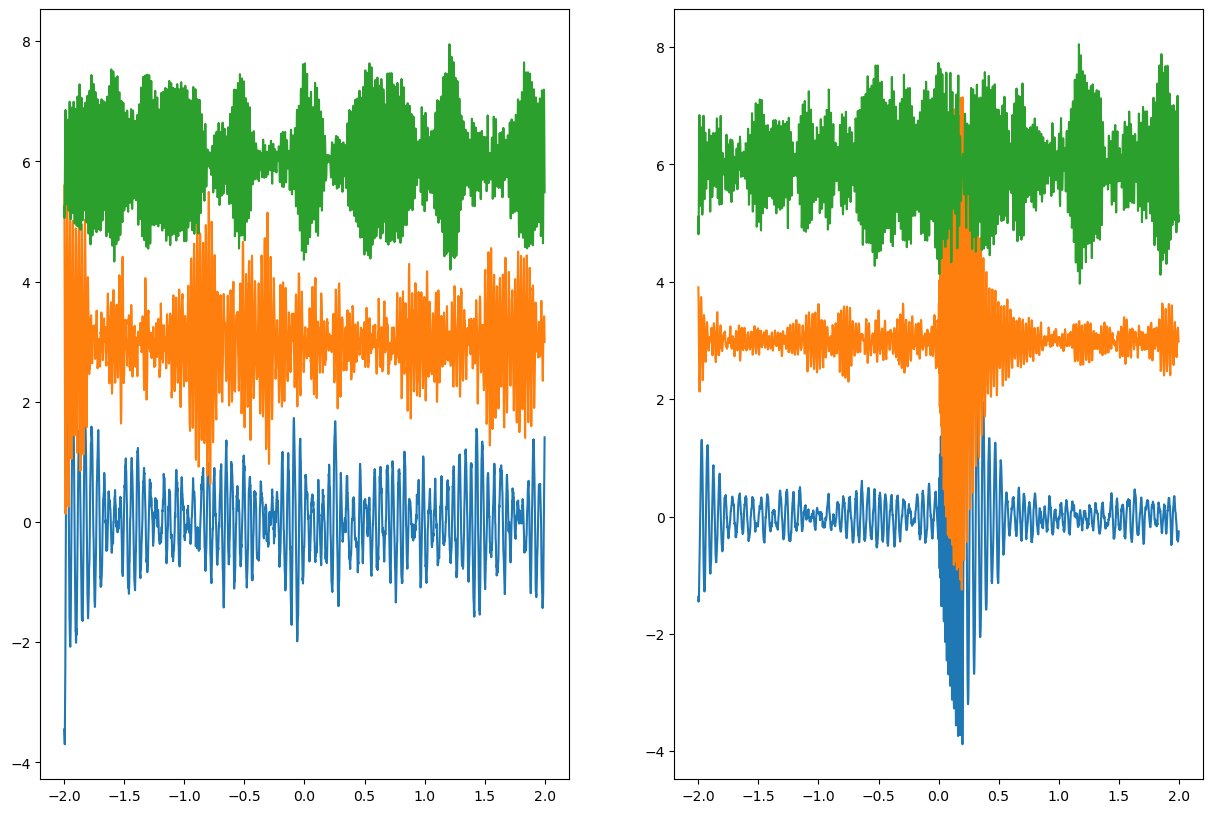

In [25]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

## Decompose in time-frequency domain

In [26]:
data = data.sel(times=slice(-0.2, 3))


freqs = np.linspace(0.3, 80, 30)

S = tfr_array_morlet(
    data.values.real,
    fsamp / 15,
    freqs,
    freqs / 7,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": data.roi.values},
)

#### MI in time-frequency domain

In [27]:
def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gc")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.array([[0, 1], [0, 2], [1, 2]])

rois = S.roi.values
stim = data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.67s/it]


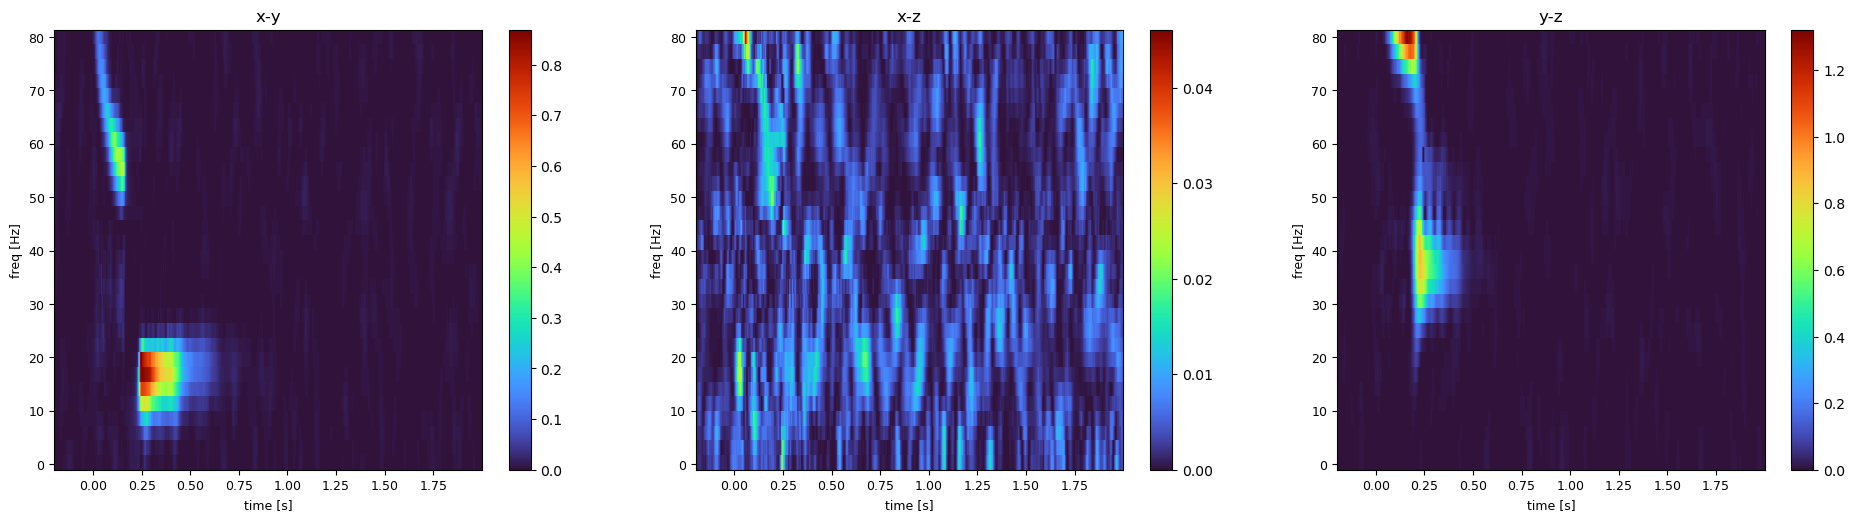

In [28]:
plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
        vmin=0,
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)

In [29]:
def WrapToPi(x):
    xwrap = x % 2 * np.pi
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    return xwrap

In [30]:
x = data.sel(roi="x") * np.conj(data.sel(roi="z"))

In [31]:
R1 = (x * np.conj(x)).data.real
R2 = np.unwrap(np.angle(x))

In [32]:
# Stims across trials
stim = np.expand_dims(Amplitudes, axis=(0, 1))
stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

In [33]:
stim.shape

(500, 1466)

In [34]:
mi_fcn = get_mi("gc")

Text(0.5, 0, 'time [s]')

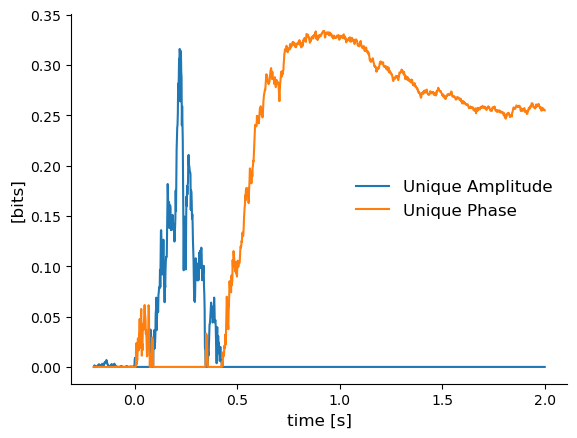

In [35]:
ax = plt.subplot(111)
I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
R_12 = np.minimum(I_S_1, I_S_2)

# plt.plot(S.times.values, I_S_12)
plt.plot(S.times.values, I_S_1 - R_12)
plt.plot(S.times.values, I_S_2 - R_12)
plt.legend(
    ["Unique Amplitude", "Unique Phase"],
    fontsize=12,
    frameon=False,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)